In [10]:
import numpy as np
from numpy.lib.recfunctions import append_fields
from numpy.lib.recfunctions import recursive_fill_fields
import numba

from scipy.spatial.distance import pdist, squareform
from itertools import combinations

import matplotlib.pyplot as plt
import matplotlib as mpl
import uproot
import awkward as ak
import pyjet
import time

from matching import matching
import np_4vect_sum as sum4vect

plt.style.use("scientific.mplstyle")

file = uproot.open("/eos/user/c/clange/PFNano/myNanoProdMc_NANO.root")
event_tree = file['Events']

In [ ]:
import pixiedust

In [11]:
max_idx = 10

pts = event_tree['PF_pt'].array(entry_stop=max_idx, library='np')
etas = event_tree['PF_eta'].array(entry_stop=max_idx, library='np')
phis = event_tree['PF_phi'].array(entry_stop=max_idx, library='np')
masses = event_tree['PF_mass'].array(entry_stop=max_idx, library='np')

pv_labels = event_tree['PF_fromPV'].array(entry_stop=max_idx, library='np')


# recojet_pts = event_tree['Jet_pt'].array(entry_stop=max_idx, library='np')
# recojet_etas = event_tree['Jet_eta'].array(entry_stop=max_idx, library='np')
# recojet_phis = event_tree['Jet_phi'].array(entry_stop=max_idx, library='np')
# recojet_masses = event_tree['Jet_mass'].array(entry_stop=max_idx, library='np')
# recojet_nconst = event_tree['Jet_nConstituents'].array(entry_stop=max_idx, library='np')

# raw_pt_factor = 1-event_tree['Jet_rawFactor'].array(entry_stop=max_idx, library='np')
# pf_recojetidx = event_tree['PF_jetsIdx'].array(entry_stop=max_idx, library='np')

In [12]:
def pyjet_jet_clustering(pts, etas, phis, masses, pv_labels, R, ptmin):
    '''Cluster jets for one event with anti kt, 15 Gev pt cut off, and CHS. It is assumed that only particles with a vertex label > 0 are signal particles'''

    event_4vect = np.column_stack((pts, etas, phis, masses)).astype('float64')
    event = np.core.records.fromarrays(event_4vect.transpose(), dtype=pyjet.DTYPE_PTEPM)
    event = append_fields(event, 'id', data=np.arange(len(event))).data
    
    chs_mask = np.where(pv_labels>0, True, False)
    event = event[chs_mask]

    sequence = pyjet.cluster(event, R=R, p=-1)
    my_jets = sequence.inclusive_jets(ptmin=ptmin)
    
    return my_jets

In [13]:
class Node():
    def __init__(self, label, is_PF = False):
        self.label = label
        self.is_leaf = is_PF
        self.parents = []
        
    def add_parents(self, parent_node1, parent_node2):
        self.parents = [parent_node1, parent_node2]
        
    def get_leaf_labels(self):
        '''Return  list of labels of all leaves of considered Node'''
        leaf_labels = []
        self._collect_leaf_nodes(self, leaf_labels)
        return leaf_labels
    
    def _collect_leaf_nodes(self, node, leaf_labels):
        if node.is_leaf:
            leaf_labels.append(node.label)
        for n in node.parents:
            self._collect_leaf_nodes(n, leaf_labels)

In [14]:
def rapidity(pt, eta, m):
    '''Accepts np.array or scalars for all inputs and returns rapidity in the format of the input'''
    return np.log((np.sqrt(m**2+pt**2*np.cosh(eta)**2) + pt*np.sinh(eta))/np.sqrt(m**2+pt**2))


@numba.vectorize
def anti_kt_dist(pt_i, pt_j, y_i, y_j, phi_i, phi_j, R):
    dphi = phi_i - phi_j
    dR2 = (y_i-y_j)**2 + ((dphi+np.pi)%(2*np.pi)-np.pi)**2
    
    return min(1/pt_i**2, 1/pt_j**2)*dR2/R**2
    

def myown_jet_clustering(pts, etas, phis, ms, pv_labels, R, ptmin):
    jet_particles = []
    jet_consti = []
    
    ys = rapidity(pts, etas, ms)
    id_nodes = [Node(i, is_PF=True) for i in range(len(pts))]
    
    event_4vect = np.column_stack((pts, etas, phis, ms)).astype('float64')
    event = np.core.records.fromarrays(event_4vect.transpose(), dtype=pyjet.DTYPE_PTEPM)
    event = append_fields(event, 'y', data=ys, dtypes='f8').data
    # add field with Node objects
    dt = event.dtype.descr + [('id_node', 'O')] # new data type, containing new field for Node object
    aux = np.empty(event.shape, dt) 
    event = recursive_fill_fields(event, aux)
    event['id_node'] = id_nodes
    
    chs_mask = np.where(pv_labels>0)[0]
    event = event[chs_mask]
    
    
    while len(event) > 1:       
        pairs = np.triu_indices(len(event),k=1)
        anti_kt_distance = anti_kt_dist(event['pT'][pairs[0]], event['pT'][pairs[1]], event['y'][pairs[0]], event['y'][pairs[1]], event['phi'][pairs[0]], event['phi'][pairs[1]], R)
        beam_distance = 1/event['pT']**2 # array d_Bi
        
        #PROBLEM CAN HAVE SEVERAL OCCURENCES OF MIN VALUE
#         min_id = np.argmin(anti_kt_distance)
#         min_anti_kt_d = anti_kt_distance[min_id]
#         min_ij = np.vstack(pairs).T[min_id]

        min_anti_kt_d = np.min(anti_kt_distance)
        anti_kt_dmin_pair_idxs = np.where(anti_kt_distance==min_anti_kt_d)[0]
        
       # choose pair with max pt
        if len(anti_kt_dmin_pair_idxs) > 1:
            pts_potential_pairs = event['pT'][pairs[0][anti_kt_dmin_pair_idxs]] + event['pT'][pairs[1][anti_kt_dmin_pair_idxs]]
            chosen_pair_id = np.argmax(pts_potential_pairs)
            min_id = anti_kt_dmin_pair_idxs[chosen_pair_id]
        else:
            min_id = anti_kt_dmin_pair_idxs[0]
            
        min_ij = np.vstack(pairs).T[min_id] # smaller index always first one on np.vstack(pairs)

#         if len(anti_kt_dmin_pair_idxs) > 1:
#             print("several mins!, {} jets clustered".format(len(jet_particles)))
#             for mind in anti_kt_dmin_pair_idxs:
#                 p = np.vstack(pairs).T
#                 q = p[mind]
#                 print("PF: {}, pT: {}".format(event['id_node'][q[0]].label, event[q[0]][['pT', 'eta', 'phi', 'mass']]))
#                 print("PF: {}, pT: {}".format(event['id_node'][q[1]].label, event[q[1]][['pT', 'eta', 'phi', 'mass']]))
#                 print("-------")
        

       
        #PROBLEM CAN HAVE SEVERAL OCCURENCES OF MIN VALUE
#         min_idx = np.argmin(beam_distance) 
#         min_beam_d = beam_distance[min_idx]
        min_beam_d = np.min(beam_distance)
        beam_dmin_idxs = np.where(beam_distance==min_beam_d)[0]
        # choose one with larger mass 
        if len(beam_dmin_idxs) > 1:
            chosen_min = np.argmax(event['mass'][beam_dmin_idxs])
            min_idx = beam_dmin_idxs[chosen_min]
        else:
            min_idx = beam_dmin_idxs[0]
            
            
        
        if (min_beam_d < min_anti_kt_d):
            # declare particle as jet if pt>=ptmin or only one particle left (return of delta_R2 is empty list)
            if event[min_idx]['pT'] >= ptmin:
                jet_particles.append(event[min_idx])
            event = np.delete(event, min_idx, axis=0)
        else:
            # find new 4 vector
            p1, p2 = event[min_ij[0]].tolist()[:4], event[min_ij[1]].tolist()[:4]
            aux = np.column_stack((p1,p2)) # 2D array where each row is pt, eta, phi, m for both particles
            new_vec4 = sum4vect.np_sum4vec(aux[0], aux[1], aux[2], aux[3])
            new_y = rapidity(new_vec4[0], new_vec4[1], new_vec4[3])
            # make new node
            parent_node1, parent_node2 = event['id_node'][min_ij[0]], event['id_node'][min_ij[1]] 
            new_node = Node(label=parent_node1.label) # smaller of the two parent labels
            new_node.add_parents(parent_node1, parent_node2)
            # change particle with smaller id to merged one and delete particle with larger id
            event[min_ij[0]] = tuple(np.concatenate((new_vec4, [new_y, new_node])))
            event = np.delete(event, min_ij[1], axis=0)
            
            
    # deal with last particle
    if event[0]['pT'] >= ptmin:
        jet_particles.append(event[0])
    event = np.delete(event, 0, axis=0)
    
    # deal with case when no jets exist
    if len(jet_particles) == 0:
        return [], [] 
    # print jets in order in which they where found
#     for j in range(len(jet_particles)):
#         print(j, jet_particles[j])
    
    # PROBLEM EVENT 67 THROWS ERROR WHEN SORTING: '<' not supported between instances of 'Node' and 'Node'
    try:
        jet_particles = np.sort(np.array(jet_particles), order=['pT', 'mass'])[::-1] # sort by decending pt and if two jets have same pt, sort those my mass
    except TypeError:
        jet_pts = [jet[0] for jet in jet_particles]
        sorting_idxs = np.argsort(jet_pts)
        jet_particles = np.array(jet_particles)[sorting_idxs]

    jets = np.empty(len(jet_particles), dtype=pyjet.DTYPE_PTEPM)
    # find PF indicies of constituents and assign jet to constituent list
    for i, jet in enumerate(jet_particles):
        jet_consti.append(np.sort(jet['id_node'].get_leaf_labels()))
        jets[i] = jet[['pT', 'eta', 'phi', 'mass']]
        
    
    
    return jets, jet_consti

In [15]:
i = 0
t3 = time.time()
myjets, myjets_consti = myown_jet_clustering(pts[i], etas[i], phis[i], masses[i], pv_labels[i], 0.4, 15)
t4 = time.time()
print(t4-t3)

1.5168609619140625


In [6]:
ptmin = 15
jet_parameter = 0.4
cluster_time_myalgo, cluster_time_pyjet = [], []
same_consti_pyjet = []
d_jetpt, d_jeteta, d_jetphi, d_jetmass = [], [], [], []

for i in range(5,6):
    print("Event ", i)
    t1 = time.time()
    pyjetjets = pyjet_jet_clustering(pts[i], etas[i], phis[i], masses[i], pv_labels[i], jet_parameter, ptmin)
    pyjets_consti = []
    for jet in pyjetjets:
        pyjets_consti.append(np.sort([consti.id for consti in jet]))
    t2 = time.time()
    cluster_time_pyjet.append(t2-t1)

    t3 = time.time()
    myjets, myjets_consti = myown_jet_clustering(pts[i], etas[i], phis[i], masses[i], pv_labels[i], jet_parameter, ptmin)
    t4 = time.time()
    cluster_time_myalgo.append(t4-t3)

    # find differences to pyjetjets
    pyjet_etas = [pyjetjet.eta for pyjetjet in pyjetjets]
    pyjet_phis = [pyjetjet.phi for pyjetjet in pyjetjets]
    matches = matching(myjets['eta'], myjets['phi'], pyjet_etas, pyjet_phis)
    same_consti_this_event = []
    
    for p,q in enumerate(matches):
        if q == -1:
            print("Couldn't find fitting pyjet to myjet {} in event {}".format(p, i))
        else:
            if len(myjets)==0 and len(pyjetjets)==0:
                continue
            d_jetpt.append(myjets[p]['pT'] - pyjetjets[q].pt)
            d_jeteta.append(myjets[p]['eta'] - pyjetjets[q].eta)
            d_jetphi.append(myjets[p]['phi'] - pyjetjets[q].phi)
            d_jetmass.append(myjets[p]['mass'] - pyjetjets[q].mass)
            
            if len(myjets_consti[p]) == len(pyjets_consti[q]):
                same_consti_this_event.append(np.allclose(myjets_consti[p], pyjets_consti[q]))
            else:
                same_consti_this_event.append(False)
                print("Different number of constituents found in myjet {}, pyjet {} of event {}.\nMy algo: {} constituents\nPyjet : {} constituents".format(p, q, i, len(myjets_consti[p]), len(pyjets_consti[q])))

Event  5


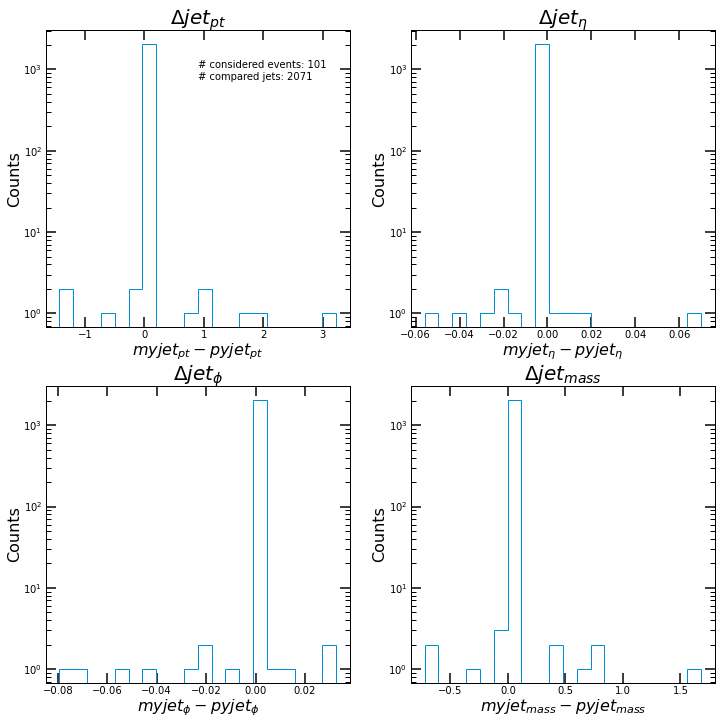

In [9]:
fig, ax = plt.subplots(2,2, figsize=(12, 12))

ax[0][0].hist(d_jetpt, bins=20, histtype='step')
ax[0][0].text(0.5, 0.9, "# considered events: {:.0f}\n# compared jets: {:.0f}".format(max_idx, len(d_jetpt)), ha='left', va='top', transform = ax[0][0].transAxes)
ax[0][0].set_title('$\Delta jet_{pt}$')
ax[0][0].set_yscale('log')
ax[0][0].set_xlabel('$myjet_{pt} - pyjet_{pt}$')
ax[0][0].set_ylabel('Counts')

ax[0][1].hist(d_jeteta, bins=20, histtype='step')
ax[0][1].set_title('$\Delta jet_{\eta}$')
ax[0][1].set_yscale('log')
ax[0][1].set_xlabel('$myjet_{\eta} - pyjet_{\eta}$')
ax[0][1].set_ylabel('Counts')

ax[1][0].hist(d_jetphi, bins=20, histtype='step')
ax[1][0].set_title('$\Delta jet_{\phi}$')
ax[1][0].set_yscale('log')
ax[1][0].set_xlabel('$myjet_{\phi} - pyjet_{\phi}$')
ax[1][0].set_ylabel('Counts')

ax[1][1].hist(d_jetmass, bins=20, histtype='step')
ax[1][1].set_title('$\Delta jet_{mass}$')
ax[1][1].set_yscale('log')
ax[1][1].set_xlabel('$myjet_{mass} - pyjet_{mass}$')
ax[1][1].set_ylabel('Counts')


plt.show()
#fig.savefig("plots/mycluster_algo_vs_pyjet101.pdf")

In [ ]:
plt.plot(np.arange(max_idx), cluster_time_myalgo, label='my algo')
plt.plot(np.arange(max_idx), cluster_time_pyjet, label='pyjet')
plt.legend()
plt.title('Comparison of cluster time')
plt.xlabel('Event id')
plt.ylabel('Cluster time in sec')
plt.show()

In [ ]:
print("Total time:\nMy Algo: {:.3f} sec\nPyjet: {:.3f} sec".format(np.sum(cluster_time_myalgo), np.sum(cluster_time_pyjet)))

# Speed check

In [ ]:
%load_ext line_profiler

In [ ]:
%lprun -f myown_jet_clustering myown_jet_clustering(pts[0], etas[0], phis[0], masses[0], pv_labels[0], 0.4, 15)
# majority of time still spend in computing anti kt distance. Note with every loop only (n-1) new distances should be compueted, while at the moment I compute all distances again

In [ ]:
# origial compare function as backup
def compare():
    ptmin = 15
    jet_parameter = 0.4
    cluster_time_myalgo, cluster_time_pyjet = [], []
    same_consti = []
    d_jetpt, d_jeteta, d_jetphi, d_jetmass = [], [], [], []
    
    for i in range(5):
        print(i)
        t1 = time.time()
        pyjetjets = pyjet_jet_clustering(pts[i], etas[i], phis[i], masses[i], pv_labels[i], jet_parameter, ptmin)
        pyjets_consti = []
        for jet in pyjetjets:
            pyjets_consti.append(np.sort([consti.id for consti in jet]))
        t2 = time.time()
        print("pyjet: ", t2-t1)
        cluster_time_pyjet.append(t2-t1)

        t3 = time.time()
        myjets, myjets_consti = myown_jet_clustering(pts[i], etas[i], phis[i], masses[i], pv_labels[i], jet_parameter, ptmin)
        t4 = time.time()
        print("myalgo: ", t4-t3)
        cluster_time_myalgo.append(t4-t3)

        # find differences
        if len(myjets) == len(pyjetjets):
            for j, (myjet, pyjetjet) in enumerate(zip(myjets, pyjetjets)):
                same_consti.append(np.allclose(pyjets_consti[j], myjets_consti[j]))
                d_jetpt.append(myjet[0]-pyjetjet.pt)
                d_jeteta.append(myjet[1]-pyjetjet.eta)
                d_jetphi.append(myjet[2]-pyjetjet.phi)
                d_jetmass.append(myjet[3]-pyjetjet.mass)
        else:
            print("Different number of jets found in event {}.\nMy algo: {} jets\nPyjet : {} jets".format(i, len(myjets), len(pyjetjets)))
        
        
    return same_consti, pyjets_consti
    #return same_consti, d_jetpt, d_jeteta, d_jetphi, d_jetmass, cluster_time_myalgo, cluster_time_pyjet

In [ ]:
same_consti, pyjet_consti = compare()